**Projeto:** Classificação de pacientes propensos a desenvolverem doenças cardíacas.

**Etapa:** 05 - Otimização

**Autor:** Dante Dantas

**Objetivo:** Realizar ajustes nos pesos e oversampling para avaliar melhorias na performance

# **Principais Insights**


*   **Balanceamento com SMOTE** *não houve melhoras no desempenho*

*   **Ajustes nos pesos** *não houve melhora significativa no desempenho*
*   **Ajuste no limiar de decisão** *não apresentou melhorias no recall*




#**Importação de pacotes**

##**Modelagem**

In [1]:
import pandas as pd
import numpy as np
import pickle

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

##**Algoritmos**

In [2]:
from sklearn.linear_model import LogisticRegression



---



##**Seleção e Metricas**

In [3]:
from sklearn.metrics import precision_recall_curve, average_precision_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, precision_score
from sklearn.metrics import confusion_matrix, classification_report, f1_score

In [52]:
from sklearn.metrics import precision_recall_curve, average_precision_score

##**Dataviz**

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

#**Importação dos dados**

In [5]:
base = pd.read_csv('/content/drive/MyDrive/Projetos/Saúde/[Classificação] Doença Cardíacas/Dados/2.TRUSTED/tb_trusted_heart_disase.csv', sep=',', encoding='utf-8')

In [6]:
# Definir features e target

features = base.iloc[:,0:11].values
target = base.iloc[:,11].values



---



# Transformação:


In [9]:
# Este ColumnTransformer fará o One-Hot Encoding e passará o resto.
# Colunas [1,2,6,8,10] originais.
# São: 'sex', 'chest_pain_type', 'resting_ecg', 'exercise_angina', 'st_slope'
column_transformer = ColumnTransformer(
    transformers=[('OneHot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), [1,2,6,8,10])],
    remainder='passthrough'
)
# Ajusta e transforma TODAS as features originais (X)
transformed_features = column_transformer.fit_transform(features)

In [10]:
#  Definir e ajustar o MinMaxScaler ---
# Aplicação sobre TODAS as colunas resultantes do 'transformed_features'.

scaler = MinMaxScaler()
transformed_features_scaled = scaler.fit_transform(transformed_features)


In [11]:
#Divisão em treino/teste e treino do modelo.
x_train, x_test, y_train, y_test = train_test_split(transformed_features_scaled, target, test_size=0.3, random_state=21)



---



# Modelo Default

In [12]:
# Importação do modelo
from sklearn.linear_model import LogisticRegression # Exemplo
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(x_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

## Validação Primária


In [13]:
def score_summary(names, classifiers):
    '''
    Dada uma lista de classificadores, esta função calcula a precisão,
    Average Precision (AP) para a Curva Precision-Recall, Recall, Precision e F1-Score
    e retorna os valores em um dataframe.
    '''


    cols = ["Classifier", "Accuracy", "Average Precision (AP)", "Recall", "Precision", "F1"]
    data_table = pd.DataFrame(columns=cols)

    for name, clf in zip(names, classifiers):
        clf.fit(x_train, y_train)

        pred = clf.predict(x_test) # Previsões das classes
        accuracy = accuracy_score(y_test, pred) # Acurácia
        pred_proba = clf.predict_proba(x_test)[:, 1] # Probabilidades da classe positiva (1)

        # precision_pr, recall_pr, thresholds_pr = precision_recall_curve(y_test, pred_proba)

        # Área Sob a Curva Precision-Recall (AP)
        average_precision = average_precision_score(y_test, pred_proba)

        # MATRIZ CONFUSÃO, cm
        cm = confusion_matrix(y_test, pred) # Matriz de Confusão

        # RECALL: TP/(TP+FN)
        recall = recall_score(y_test, pred)

        # PRECISÃO: TP/(TP+FP)
        precision = precision_score(y_test, pred)

        # MEDIDA F1
        f1 = f1_score(y_test, pred)

        # Adiciona os resultados ao DataFrame
        df = pd.DataFrame([[name, accuracy * 100, average_precision, recall, precision, f1]], columns=cols)
        data_table = pd.concat([data_table, df], ignore_index=True)

    return np.round(data_table.reset_index(drop=True), 2)

In [14]:
# Avaliação Primária sem otimizações
names = ["Logistic Regression"]
classifiers = [model]

In [15]:
 score_summary(names, classifiers).sort_values(by='Recall' , ascending = False)\
.style.background_gradient(cmap='Blues')\
.bar(subset=["Average Precision (AP)"], color='#5d82c7')\
.bar(subset=["Recall"], color='#779ad5')\
.bar(subset=["Precision"], color='#90b3e3')\
.bar(subset=["F1"], color='#aacbf1')

/tmp/ipython-input-13-2866274301.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_table = pd.concat([data_table, df], ignore_index=True)


,Classifier,Accuracy,Average Precision (AP),Recall,Precision,F1
0,Logistic Regression,86.550000,0.920000,0.890000,0.870000,0.880000


#**Otimização Hiperparâmetros**

##**Importação de pacotes**

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
from sklearn.metrics import make_scorer, average_precision_score #curva Precision-Recall

##**Oversampling**

In [18]:
from imblearn.over_sampling import SMOTE

In [19]:
smote = SMOTE(random_state=42)

In [20]:
X_resampled, y_resampled = smote.fit_resample(x_train, y_train)

In [21]:
# Verificar o balanceamento após SMOTE
print("Distribuição após SMOTE:", dict(zip(*np.unique(y_resampled, return_counts=True))))

Distribuição após SMOTE: {np.int64(0): np.int64(353), np.int64(1): np.int64(353)}


In [22]:
model_smote = LogisticRegression(max_iter=1000, random_state=42)
model_smote.fit(X_resampled, y_resampled)

LogisticRegression(max_iter=1000, random_state=42)

In [24]:
y_pred = model_smote.predict(x_test)

In [ ]:
names = ["Logistic Regression"]
classifiers = [model_smote]

In [26]:
 score_summary(names, classifiers).sort_values(by='Recall' , ascending = False)\
.style.background_gradient(cmap='Blues')\
.bar(subset=["Average Precision (AP)"], color='#5d82c7')\
.bar(subset=["Recall"], color='#779ad5')\
.bar(subset=["Precision"], color='#90b3e3')\
.bar(subset=["F1"], color='#aacbf1')

/tmp/ipython-input-13-2866274301.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_table = pd.concat([data_table, df], ignore_index=True)


,Classifier,Accuracy,Average Precision (AP),Recall,Precision,F1
0,Logistic Regression,86.550000,0.920000,0.890000,0.870000,0.880000


##**Otimização de pesos**

In [30]:
model_optimizad =  LogisticRegression(
    random_state=42
 )

In [27]:
# Definindo o scorer para a Average Precision (AP)
# 'pos_label=1' é importante pois a classe positiva é 1
pr_scorer = make_scorer(average_precision_score, needs_proba=True, pos_label=1)

In [44]:
param_grid = [
    {
        'solver': ['liblinear'], # Solver que suporta 'l1'
        'penalty': ['l1', 'l2'],
        'C': [0.1, 1, 10, 100,1000], # Valores para a força de regularização
        'class_weight': [None, 'balanced'], # Para lidar com desbalanceamento
        'fit_intercept': [True, False],
        'dual': [False] # dual=True só com l2 e liblinear, mas geralmente dual=False é melhor para n_samples > n_features
    },
    {
        'solver': ['newton-cg', 'lbfgs'], # Solvers que só suportam 'l2'
        'penalty': ['l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'class_weight': [None, 'balanced'],
        'fit_intercept': [True, False],
        'max_iter': [1000, 2000] # Aumentar max_iter para garantir convergência nesses solvers
    }
]

In [45]:
# Configuração do GridSearch
grid_search = GridSearchCV(
    estimator = model_optimizad,
    param_grid = param_grid,
    scoring = pr_scorer, # Usando o scorer de Average Precision (AP)
    cv = 5,              # Validação cruzada com 5 divisões
    verbose = 2,         # Para ver o progresso
    n_jobs = -1          # Usar todos os núcleos disponíveis para paralelização
)

In [46]:
# Executando o Grid Search
print("Iniciando Grid Search...")
grid_search.fit(x_train, y_train) # Ajusta o Grid Search aos seus dados de treino

Iniciando Grid Search...
Fitting 5 folds for each of 136 candidates, totalling 680 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid=[{'C': [0.1, 1, 10, 100, 1000],
                          'class_weight': [None, 'balanced'], 'dual': [False],
                          'fit_intercept': [True, False],
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'class_weight': [None, 'balanced'],
                          'fit_intercept': [True, False],
                          'max_iter': [1000, 2000], 'penalty': ['l2'],
                          'solver': ['newton-cg', 'lbfgs']}],
             scoring=make_scorer(average_precision_score, response_method='predict', needs_proba=True, pos_label=1),
             verbose=2)

In [47]:
print("\nGrid Search Concluído!")
print(f"Melhores parâmetros encontrados: {grid_search.best_params_}")
print(f"Melhor Average Precision (AP) no conjunto de validação: {grid_search.best_score_:.4f}")


Grid Search Concluído!
Melhores parâmetros encontrados: {'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}
Melhor Average Precision (AP) no conjunto de validação: nan


In [48]:
# Você pode acessar o melhor modelo assim:
best_model = grid_search.best_estimator_
best_model

LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='liblinear')

In [49]:
# Avaliar o modelo no conjunto de teste
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(x_test)[:, 1]
average_precision = average_precision_score(y_test, y_pred_proba)
print("Average Precision no conjunto de teste:", average_precision)

Average Precision no conjunto de teste: 0.9074605096716313


#**Modelo Otimizado**

##**Criação dos modelos**

In [38]:
names = ["Logistic Regression"]

In [50]:
classifiers = [

    LogisticRegression(
        C=0.1,
        penalty='l1',
        random_state=42,
        solver='liblinear'

    )
]

##**Métricas, Ajuste e Transformação**

In [51]:
 score_summary(names, classifiers).sort_values(by='Recall' , ascending = False)\
.style.background_gradient(cmap='Blues')\
.bar(subset=["Average Precision (AP)"], color='#5d82c7')\
.bar(subset=["Recall"], color='#779ad5')\
.bar(subset=["Precision"], color='#90b3e3')\
.bar(subset=["F1"], color='#aacbf1')

/tmp/ipython-input-13-2866274301.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_table = pd.concat([data_table, df], ignore_index=True)


,Classifier,Accuracy,Average Precision (AP),Recall,Precision,F1
0,Logistic Regression,88.000000,0.910000,0.930000,0.860000,0.900000


In [54]:
def precision_recall_plot(names, classifiers):
    '''
    Dada uma lista de classificadores, esta função traça as curvas Precision-Recall.

    Args:
        names (list): Uma lista de strings com os nomes dos classificadores.
        classifiers (list): Uma lista de objetos classificadores (modelos) já treinados
                            ou que serão treinados dentro da função.
    '''
    plt.figure(figsize=(12, 8)) # Define o tamanho da figura

    for name, clf in zip(names, classifiers):
        # Treina o classificador no conjunto de treino

        clf.fit(x_train, y_train)

        # Obtém as probabilidades preditas para a classe positiva (geralmente a coluna 1)
        pred_proba = clf.predict_proba(x_test)[:, 1]

        # --- Alteração principal: Usando precision_recall_curve ---
        # Calcula os valores de Precision e Recall para diferentes limiares
        precision, recall, _ = precision_recall_curve(y_test, pred_proba) # '_' ignora os thresholds

        # Calcula a Área Sob a Curva Precision-Recall (Average Precision)
        ap_score = average_precision_score(y_test, pred_proba)

        # Plota a curva Precision-Recall para o classificador atual
        plt.plot(recall, precision, lw=3, label=f'{name} PR curve (AP = {ap_score:.2f})')

    # --- Configurações do plot ---
    plt.xlabel('Recall (Revocação)', fontsize=14) # Rótulo do eixo X
    plt.ylabel('Precision (Precisão)', fontsize=14) # Rótulo do eixo Y
    plt.title('Curvas Precision-Recall', fontsize=20) # Título do gráfico
    plt.ylim([0.0, 1.05]) # Limites do eixo Y
    plt.xlim([0.0, 1.05]) # Limites do eixo X
    plt.grid(True) # Adiciona uma grade ao gráfico
    plt.legend(loc="lower left", fontsize=12) # Adiciona a legenda no canto inferior esquerdo
    plt.show() # Exibe o gráfico

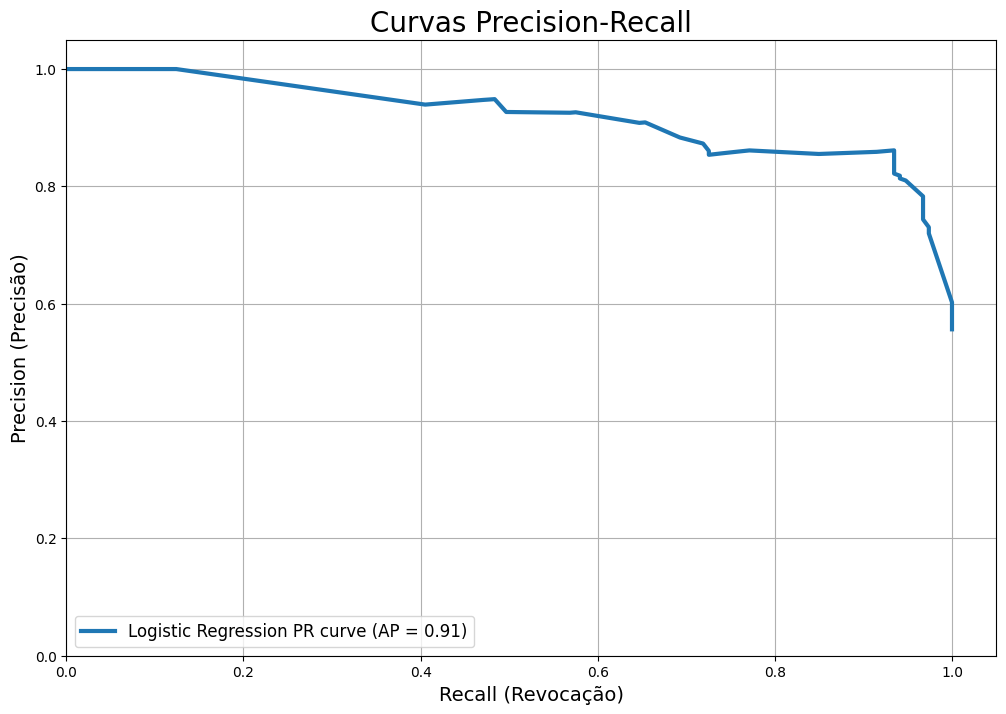

In [55]:
# Visualizando a curva precision-recall:
precision_recall_plot(
    names= names,
    classifiers=classifiers
)



---



# Pontos de Cortes [Teste]


In [56]:
import numpy as np
from sklearn.metrics import precision_recall_curve

def get_recall_for_precision(y_true, pred_proba, target_precisions):
    '''
    Calcula o Recall para valores de Precisão específicos a partir da curva Precision-Recall.

    Args:
        y_true (array-like): Rótulos verdadeiros das classes.
        pred_proba (array-like): Probabilidades previstas para a classe positiva.
        target_precisions (list): Uma lista de valores de precisão para os quais se deseja encontrar o Recall.

    Returns:
        dict: Um dicionário onde as chaves são os valores de precisão desejados
              e os valores são os Recall correspondentes.
    '''
    # Calcula os arrays de precisão, recall e thresholds
    precision, recall, thresholds = precision_recall_curve(y_true, pred_proba)

    results = {}
    for target_p in target_precisions:
        # Encontra o índice onde a precisão é a primeira vez >= ao target_p
        # Usamos np.where para encontrar todos os índices onde a condição é satisfeita
        # E np.argmax para pegar o primeiro índice onde a precisão atinge ou ultrapassa o target_p
        # Iteramos do final para o começo do array de precisão, pois ele é decrescente
        # para recalls crescentes. Ou, o mais simples, encontrar todos os pontos onde precision >= target_p
        # e pegar o maior recall associado a eles.

        # Filtra os recalls onde a precisão é maior ou igual ao target_p
        # Note que precision e recall são ordenados por threshold.
        # Queremos o recall mais alto (mais à direita na curva) que ainda atenda
        # à precisão mínima desejada.
        # precision[-1] é 1.0 (ou próximo) e recall[-1] é 0.0 (ou próximo).
        # precision[0] é o que corresponde ao recall mais alto.
        # É mais fácil percorrer do fim (thresholds menores) para o início (thresholds maiores).

        # A curva precision_recall_curve retorna os arrays de forma que
        # precision[i] e recall[i] correspondem ao mesmo threshold.
        # precision[-1] é 1.0 e recall[-1] é 0.0, correspondendo a um threshold alto.
        # precision[0] é o valor para o recall mais alto (threshold mais baixo).

        # Para obter o recall "máximo" para uma dada precisão,
        # precisamos encontrar o ponto na curva onde a Precisão é >= ao valor desejado,
        # e, dentre esses pontos, escolher aquele com o maior Recall.

        # Indices onde a precisão é >= ao valor alvo
        indices_validos = np.where(precision >= target_p)[0]

        if len(indices_validos) > 0:
            # Entre os índices válidos, o último índice geralmente corresponde ao
            # maior recall para essa precisão (ou um dos maiores).
            # Ou podemos pegar o recall máximo dentre esses pontos.
            max_recall_for_target_p = np.max(recall[indices_validos])
            results[target_p] = max_recall_for_target_p
        else:
            results[target_p] = None # Não foi possível atingir essa precisão

    return results

# --- Exemplo de Uso ---
# Supondo que você já tenha 'y_test' e 'best_model' do seu GridSearch.
# Obtenha as probabilidades do seu melhor modelo no conjunto de teste.
pred_proba_best_model = best_model.predict_proba(x_test)[:, 1]

# Defina as precisões que você quer investigar
target_precisions = [0.80, 0.78]

# Chame a nova função
recall_insights = get_recall_for_precision(y_test, pred_proba_best_model, target_precisions)

print("\nRecall para Precisões Desejadas:")
for p, r in recall_insights.items():
    if r is not None:
        print(f"Quando a Precisão é de pelo menos {p*100:.0f}%, o Recall máximo é de {r*100:.2f}%")
    else:
        print(f"Não foi possível atingir uma Precisão de {p*100:.0f}% com este modelo.")


Recall para Precisões Desejadas:
Quando a Precisão é de pelo menos 80%, o Recall máximo é de 94.77%
Quando a Precisão é de pelo menos 78%, o Recall máximo é de 96.73%


#**Validação Cruzada**

In [60]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [61]:
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    precision_recall_curve,
    auc,
    average_precision_score
)

In [62]:
def cross_validation(names, classifiers, X_original, y_original, preprocessor_pipeline, n_splits=5):
    '''
    Realiza a validação cruzada usando KFold e calcula métricas de avaliação para cada classificador.
    Utiliza um Pipeline para garantir que o pré-processamento seja aplicado corretamente em cada fold,
    evitando vazamento de dados.

    Args:
        names (list): Lista de nomes dos classificadores.
        classifiers (list): Lista de classificadores (instâncias de modelos).
        X_original (numpy.ndarray): Dados de entrada (features) ORIGINAIS, sem pré-processamento inicial.
        y_original (numpy.ndarray): Labels (saída) ORIGINAIS.
        preprocessor_pipeline (sklearn.compose.ColumnTransformer ou sklearn.pipeline.Pipeline):
            O transformador que realiza o OneHotEncoding e outras transformações, seguido pelo escalonamento.
        n_splits (int): Número de folds para o KFold.

    Retorna:
        pd.DataFrame: Um DataFrame com as métricas médias de cada classificador.
    '''
    cols = ["Classifier", "Accuracy", "Average Precision (AP)", "Recall", "Precision", "F1"] # Renomeei PR_AUC para AP
    data_table = pd.DataFrame(columns=cols)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for name, clf in zip(names, classifiers):
        accuracies, ap_scores, recalls, precisions, f1_scores = [], [], [], [], []

        # Criar o Pipeline para o classificador atual
        # O pipeline inclui: pré-processamento (OneHotEncoder + MinMaxScaler) e o classificador
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor_pipeline), # Usa o preprocessor_pipeline passado como argumento
            ('scaler', MinMaxScaler()),              # MinMaxScaler aplicado DEPOIS do OneHotEncoder
            ('classifier', clf)                      # O classificador final
        ])

        for fold, (train_index, test_index) in enumerate(kf.split(X_original)):
            print(f"Processando {name} - Fold {fold+1}/{n_splits}...")

            # Divide os dados ORIGINAIS em treino e teste para o fold atual
            X_train_fold, X_test_fold = X_original[train_index], X_original[test_index]
            y_train_fold, y_test_fold = y_original[train_index], y_original[test_index]

            # Ajusta e transforma o pipeline SOMENTE nos dados de treino do fold
            # e depois transforma os dados de teste do fold.
            pipeline.fit(X_train_fold, y_train_fold)

            # Previsões e probabilidades no conjunto de teste do fold
            pred = pipeline.predict(X_test_fold)
            pred_proba = pipeline.predict_proba(X_test_fold)[:, 1]

            # Métricas
            accuracies.append(accuracy_score(y_test_fold, pred))
            # Usando average_precision_score diretamente para a Área Sob a Curva Precision-Recall (AP)
            ap_scores.append(average_precision_score(y_test_fold, pred_proba))
            recalls.append(recall_score(y_test_fold, pred))
            precisions.append(precision_score(y_test_fold, pred))
            f1_scores.append(f1_score(y_test_fold, pred))

        # Média das métricas para todos os folds
        df = pd.DataFrame([[name,
                            np.mean(accuracies) * 100,
                            np.mean(ap_scores), # Média da Average Precision
                            np.mean(recalls),
                            np.mean(precisions),
                            np.mean(f1_scores)]],
                          columns=cols)
        data_table = pd.concat([data_table, df], ignore_index=True)

    return np.round(data_table.reset_index(drop=True), 2)


# --- Exemplo de como chamar a função de validação cruzada ---
# O 'classifiers' e 'preprocessor' já vêm definidos do seu código principal
# Certifique-se de usar 'features_original' e 'target_original'
# E o 'preprocessor' definido ANTES da função

names = ["Logistic Regression"]
classifiers = [
    LogisticRegression(
        C=0.1,
        penalty='l1',
        random_state=42,
        solver='liblinear'
    )
]

In [64]:
preprocessor = ColumnTransformer(
    transformers=[
        ('OneHot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), [1,2,6,8,10])
    ],
    remainder='passthrough'
)

In [65]:
# Validação cruzada para verificar overfitting
cv_results = cross_validation(names, classifiers, features, target, preprocessor, n_splits=5)
print(cv_results)

Processando Logistic Regression - Fold 1/5...
Processando Logistic Regression - Fold 2/5...
Processando Logistic Regression - Fold 3/5...
Processando Logistic Regression - Fold 4/5...
Processando Logistic Regression - Fold 5/5...
            Classifier  Accuracy  Average Precision (AP)  Recall  Precision  \
0  Logistic Regression     86.78                    0.92    0.92       0.86   

     F1  
0  0.88  


/tmp/ipython-input-62-59577800.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_table = pd.concat([data_table, df], ignore_index=True)


In [67]:
# Exibir resultados com ordenação e estilo
cv_results.sort_values(by='Recall', ascending=False)\
    .style.background_gradient(cmap='coolwarm')


,Classifier,Accuracy,Average Precision (AP),Recall,Precision,F1
0,Logistic Regression,86.780000,0.920000,0.920000,0.860000,0.880000


#**Matriz de Confusão**

In [68]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

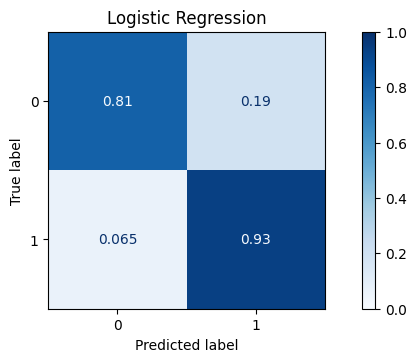

In [69]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))  # Ajustar o tamanho total da figura

for i, (name, clf) in enumerate(zip(names, classifiers), start=1):
    clf.fit(x_train, y_train)  # Ajustar o modelo
    ax = plt.subplot(3, 2, i)  # Configurar os subplots

    # Gerar matriz de confusão normalizada
    disp = ConfusionMatrixDisplay.from_estimator(
        clf, x_test, y_test, ax=ax, cmap='Blues', normalize='true'
    )

    # Configurar título e ajustar elementos visuais
    ax.set_title(name, fontsize=12)  # Reduzir o tamanho da fonte do título
    ax.tick_params(axis='both', which='major', labelsize=10)  # Reduzir tamanho das labels
    disp.im_.set_clim(0, 1)  # Fixar o range de valores da cor entre 0 e 1

plt.tight_layout()
plt.show()




---



#Etapas

Próximas etapas:


10.   Explicabilidade do modelo
11.  Deploy

